<a href="https://colab.research.google.com/github/techzro/ML4CPS-Project-1/blob/main/ML_project_Are_you_safe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 400
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 30

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Project 1 Data/Train_Data",
    shuffle = True,
    image_size =(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE
)

Found 2516 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['A', 'B', 'C', 'D', 'S']

In [ ]:
len(dataset)

79

In [ ]:
for image_batch, labels_batch in dataset.take(1): # reading images in 1 batch
    print(image_batch.shape)
    print(labels_batch.numpy())
   # print(image_batch[0].numpy())
    print(image_batch[0].shape)

(32, 400, 300, 3)
[0 0 3 3 2 1 0 2 3 2 0 3 3 0 4 3 2 3 3 2 4 3 4 2 4 2 1 2 3 3 3 1]
(400, 300, 3)


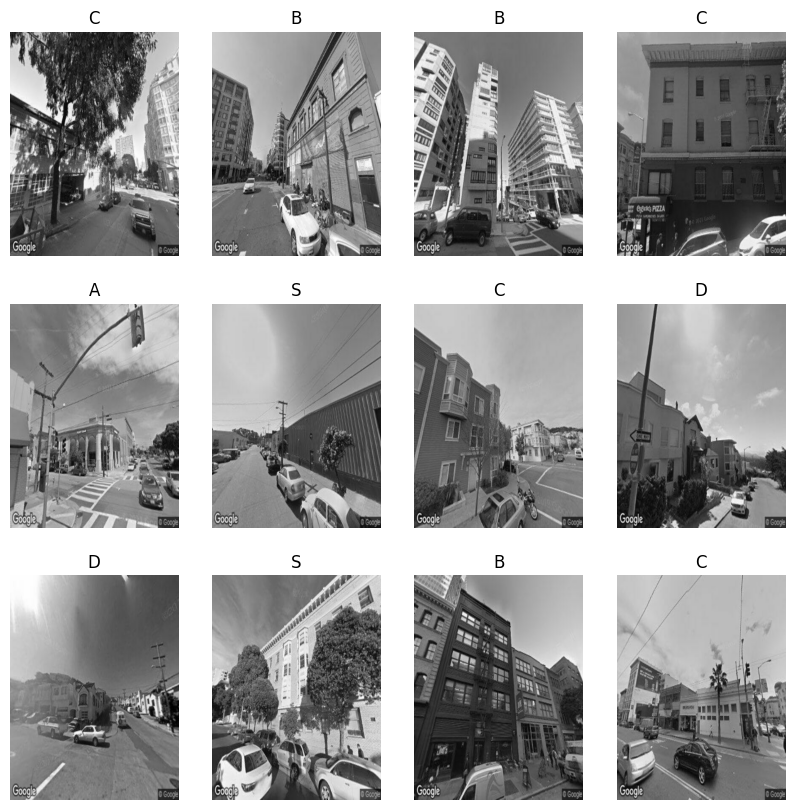

In [ ]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range (12):
    plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(len(train_ds), len(val_ds), len(test_ds))

63 7 9


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

In [ ]:
# train_ds = dataset.map(lambda x, y: (resize_and_rescale(x), y))
# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# input_shape = (BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
# n_classes = 5


# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(128, activation = 'relu'),
#     layers.Dense(n_classes, activation = 'softmax'),
# ])

# model.build(input_shape = input_shape)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pool the features
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(5, activation='softmax')(x)  # 5 output classes


In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 400, 300, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 406, 306, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 200, 150, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 200, 150, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 200, 150, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 202, 152, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 100, 75, 64)    │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 100, 75, 64)    │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 100, 75, 64)    │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 100, 75, 64)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 100, 75, 64)    │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 100, 75, 64)    │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 100, 75, 64)    │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 100, 75, 256)   │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 100, 75, 256)   │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,691,013 (98.00 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore the best weights
)

model_checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/building/best_model.keras',  # Filepath to save the model
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min'  # We want the minimum validation loss
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by half
    patience=3,         # Wait 3 epochs before reducing
    min_lr=1e-6         # Minimum learning rate
)

In [ ]:

history = model.fit(
     train_ds,
     epochs = EPOCHS,
     batch_size = BATCH_SIZE,
     verbose = 1,
     validation_data = val_ds,
     callbacks=[early_stopping, model_checkpoint, reduce_lr]
 )

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 450s 613ms/step - accuracy: 0.3860 - loss: 2.0425 - val_accuracy: 0.6161 - val_loss: 1.0815 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 280ms/step - accuracy: 0.5987 - loss: 1.0869 - val_accuracy: 0.6562 - val_loss: 0.9265 - learning_rate: 0.0010
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.6228 - loss: 0.9697 - val_accuracy: 0.6562 - val_loss: 0.8847 - learning_rate: 0.0010
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 352ms/step - accuracy: 0.6622 - loss: 0.8860 - val_accuracy: 0.7098 - val_loss: 0.7785 - learning_rate: 0.0010
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accuracy: 0.6954 - loss: 0.8227 - val_accuracy: 0.6964 - val_loss: 0.7721 - learning_rate: 0.0010
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 462ms/step - accuracy: 0.7485 - loss: 0.7035 - val_accuracy: 0.7500 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 493ms/step - accuracy: 0.7755 - loss: 0

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/my_building_9018.keras')

In [ ]:
scores = model.evaluate(test_ds)
scores

9/9 ━━━━━━━━━━━━━━━━━━━━ 199s 14s/step - accuracy: 0.9143 - loss: 0.3307


[0.31998807191848755, 0.9131944179534912]

In [ ]:
model

<Functional name=functional, built=True>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)  # Create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])))
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


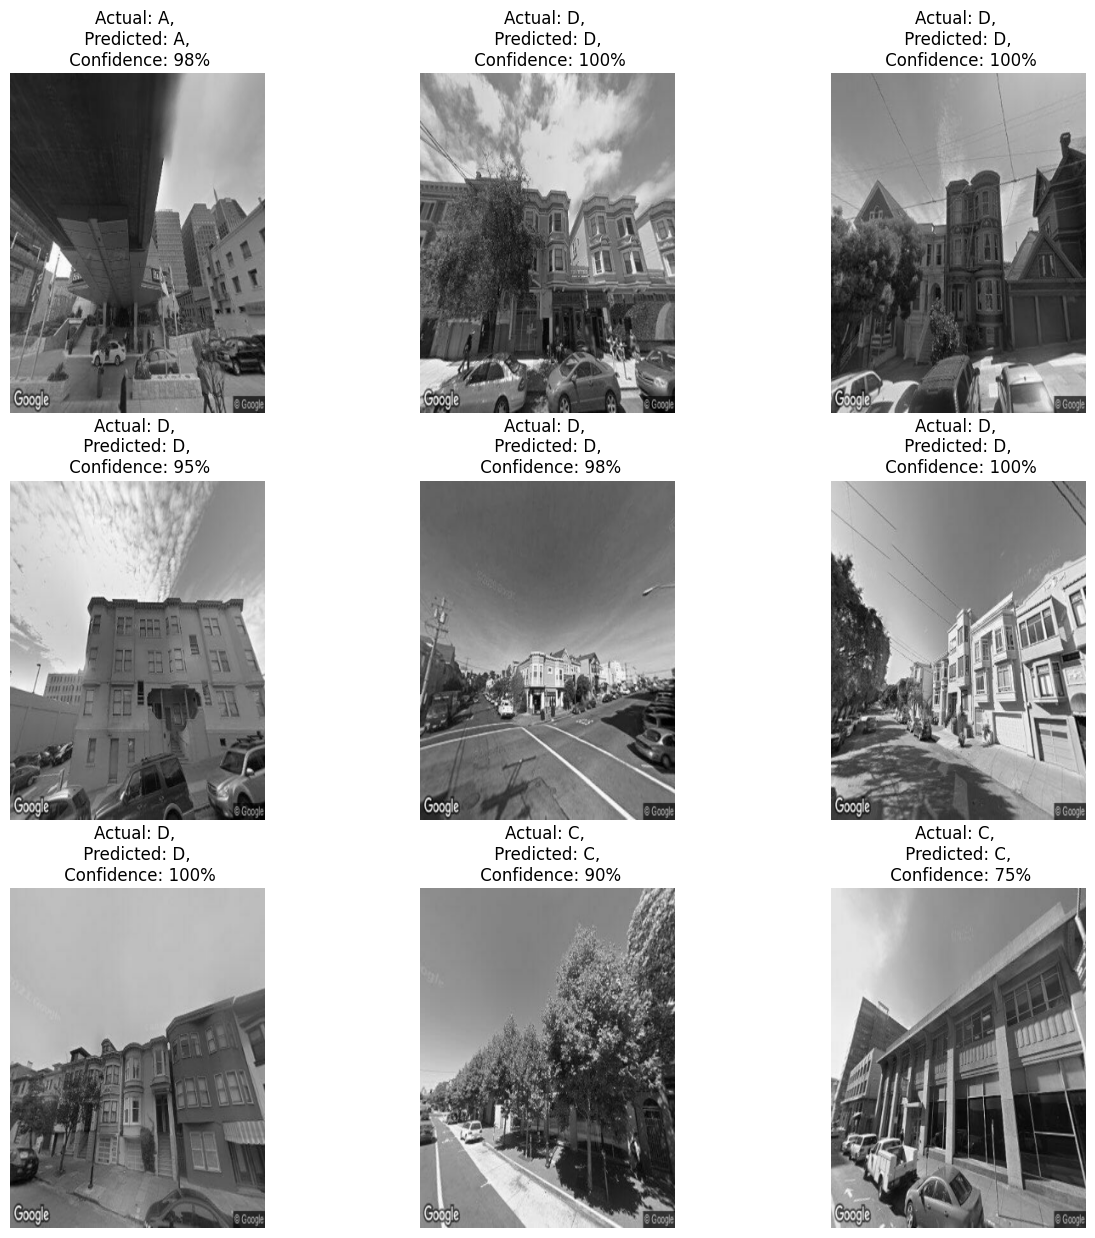

In [ ]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")

    plt.axis("off")

In [ ]:
# Save the model to Google Drive
model.save('/content/drive/My Drive/Colab Notebooks/my_building_9018.keras')

In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/my_building_9018.keras')

In [ ]:
submission_counter = 1

In [ ]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/Project 1 Data/Test_Data'

In [ ]:
test_image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

In [ ]:
ids = []
predictions = []

In [ ]:
for img_file in test_image_files:
  img_path = os.path.join(test_dir, img_file)
  img = image.load_img(img_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, 0)
  img_array /= 255.0

  pred = model.predict(img_array)
  predicted_class = np.argmax(pred, axis=1)[0]


  ids.append(len(ids) + 1)
  predictions.append(predicted_class)

In [ ]:
unique, frequency = np.unique(predictions, return_counts=True)
print(unique, frequency)

[2] [478]


In [ ]:
submission_df = pd.DataFrame({'ID': ids, 'Prediction': predictions})
submission_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/submission_90.csv', index=False)

In [ ]:
submission_counter += 1

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

# Load your trained model
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/my_building_9018.keras')  # Update with your model path

# Define the class names (update this list based on your model)
# class_names = ['A', 'B', 'C', 'D', 'S']  # Update this list

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])))
    return predicted_class, confidence

# Path to the Test_data folder
test_data_folder = '/content/drive/MyDrive/Colab Notebooks/Project 1 Data/Test_Data'

# Initialize lists to store IDs and predictions
ids = []
predictions = []
labels = ['A','B','C','D','S']

# Loop through all images in the Test_data folder
for i in range(1, 479):  # IDs from 1 to 478
    image_path = os.path.join(test_data_folder, f'{i}.jpg')

    if os.path.exists(image_path):
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))  # Specify the target size
        predicted_class, confidence = predict(model, img)

        ids.append(i)
        predictions.append(labels.index(predicted_class)+1)  # You can include confidence if needed
    else:
        print(f"Image {image_path} not found.")

# Create a DataFrame from the lists
results_df = pd.DataFrame({
    'ID': ids,
    'Prediction': predictions
})

# Save the DataFrame to a CSV file
results_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/submission_90_new.csv', index=False)
print("Predictions saved to predictions.csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 